In [3]:
%load_ext autoreload
%autoreload

import json
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import tqdm
import random
import torch
import sklearn
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from transformers import XLMTokenizer, XLMModel, XLMConfig

from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
import inlp, inlp_dataset_handler, inlp_linear_model
import copy
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import pandas as pd

I0226 17:38:19.780352 140323841980224 file_utils.py:35] PyTorch version 1.3.1 available.
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

In [110]:
with open('tweets.above-100.no-retweets.no-http.txt', "r", encoding = "utf-8") as f:
  lines = f.readlines()

all_data = []

for line in tqdm_notebook(lines[:]):
    d = eval(line) #json.loads(line)
    text = d["text"]
    lang = d["lang"]
    all_data.append({"text": text.replace("\n", "."), "lang": lang})

### Load parallal TED dataset

In [40]:
import pandas as pd
df = pd.read_csv("all_talks_train.tsv", sep = "\t")
df = df[df["en"].str.len() > 75]
df = df.dropna()
del df["talk_name"]
all_langs = list(df.columns.values)
all_data = []

for lang in all_langs:
    
    relevant = df[lang].tolist()
    
    for sent in relevant:
        if "NULL" not in sent:
            all_data.append({"text": sent.replace("\n", ".").replace("&apos;", "'"), "lang": lang})
        

In [41]:
df["fr"].tolist()[2]

'Mais la situation évolue , et nous constatons qu&apos; il y a de nouveaux acteurs clés qui arrivent sur la scène .'

In [42]:
from collections import Counter
lang_counter = Counter()
for lang in all_langs:
    
    relevant = [d for d in all_data if d["lang"] == lang]
    lang_counter[lang] = len(relevant)

common_langs = lang_counter.most_common(25)
print(common_langs)
common_langs, _ = list(zip(*common_langs))
langs = common_langs

[('en', 143855), ('ar', 118593), ('he', 116799), ('ru', 114324), ('ko', 112382), ('it', 112090), ('ja', 111700), ('zh-tw', 110225), ('zh-cn', 108744), ('es', 105818), ('fr', 103601), ('tr', 99313), ('pt-br', 98664), ('nl', 98293), ('ro', 98175), ('bg', 95888), ('pl', 95608), ('vi', 93708), ('de', 89798), ('fa', 83056), ('hu', 80107), ('sr', 73599), ('el', 71440), ('hr', 66600), ('uk', 59270)]


In [43]:
lang_counter

Counter({'en': 143855,
         'es': 105818,
         'pt-br': 98664,
         'fr': 103601,
         'ru': 114324,
         'he': 116799,
         'ar': 118593,
         'ko': 112382,
         'zh-cn': 108744,
         'it': 112090,
         'ja': 111700,
         'zh-tw': 110225,
         'nl': 98293,
         'ro': 98175,
         'tr': 99313,
         'de': 89798,
         'vi': 93708,
         'pl': 95608,
         'pt': 23747,
         'bg': 95888,
         'el': 71440,
         'fa': 83056,
         'sr': 73599,
         'hu': 80107,
         'hr': 66600,
         'uk': 59270,
         'cs': 55246,
         'id': 46238,
         'th': 53921,
         'sv': 28460,
         'sk': 32751,
         'sq': 23644,
         'lt': 22238,
         'da': 24124,
         'calv': 0,
         'my': 11399,
         'sl': 10543,
         'mk': 13867,
         'fr-ca': 10342,
         'fi': 12658,
         'hy': 11105,
         'hi': 9858,
         'nb': 8326,
         'ka': 6700,
         'mn':

In [47]:
data = []
n = 5000

#langs = ["en", "ar", "es", "pt", "it", "fr", "in", "hi", "de", "ru", "nl", "ja", "th", "tl"]
#langs = ["en", "es", "it", "pt", "ru", "hi", "de", "fr", "ar", "iw", "nl", "fa", "ur", "pl", "th", "ro", "sv", "ta", "ja", "ko"]
for lang in langs:    
    lang_tweets = [d for d in all_data if d["lang"] == lang]
    for i in range(n):
        tweet = random.choice(lang_tweets)
        data.append({"lang": lang, "text": tweet["text"]})
        
random.shuffle(data)

In [48]:
data[5]

{'lang': 'tr',
 'text': 'Yani doğa şunu yapmanıza izin vermez — hani üzüm bitkisine mühendislik uygulayabiliriz , ama'}

In [50]:
from collections import Counter
all_langs = [d["lang"] for d in all_data]
counter = Counter(all_langs)
print(counter.most_common(100))

[('en', 143855), ('ar', 118593), ('he', 116799), ('ru', 114324), ('ko', 112382), ('it', 112090), ('ja', 111700), ('zh-tw', 110225), ('zh-cn', 108744), ('es', 105818), ('fr', 103601), ('tr', 99313), ('pt-br', 98664), ('nl', 98293), ('ro', 98175), ('bg', 95888), ('pl', 95608), ('vi', 93708), ('de', 89798), ('fa', 83056), ('hu', 80107), ('sr', 73599), ('el', 71440), ('hr', 66600), ('uk', 59270), ('cs', 55246), ('th', 53921), ('id', 46238), ('sk', 32751), ('sv', 28460), ('da', 24124), ('pt', 23747), ('sq', 23644), ('lt', 22238), ('mk', 13867), ('fi', 12658), ('my', 11399), ('hy', 11105), ('sl', 10543), ('fr-ca', 10342), ('hi', 9858), ('nb', 8326), ('ka', 6700), ('ku', 5868), ('et', 5711), ('gl', 5168), ('mr', 4870), ('mn', 3639), ('ur', 3184), ('eo', 3166), ('ta', 3149), ('az', 3126), ('bs', 2946), ('eu', 2755), ('ms', 2689), ('bn', 2564), ('zh', 2397), ('be', 2383), ('kk', 1709)]


## Run BERT

In [161]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu', model = "bert"):

        if model == "bert":
            config = BertConfig.from_pretrained("bert-base-multilingual-uncased", output_hidden_states=True)
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
            self.model = BertModel.from_pretrained('bert-base-multilingual-uncased', config = config)
        else:
            config = XLMConfig.from_pretrained("xlm-mlm-100-1280", output_hidden_states=True)
            self.tokenizer = XLMTokenizer.from_pretrained("xlm-mlm-100-1280")
            self.model = XLMModel.from_pretrained("xlm-mlm-100-1280", config = config)

        #config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        #self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
        
        #config = AlbertConfig.from_pretrained("albert-xlarge-v2", output_hidden_states=True)
        #self.tokenizer = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
        #self.model = AlbertModel.from_pretrained("albert-xlarge-v2", config = config)
        #config = RobertaConfig.from_pretrained("roberta-large", output_hidden_states=True)
        #self.tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        #self.model = RobertaModel.from_pretrained('roberta-large', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str]) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """
        
        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        tokenized_text = tokenized_text[:512]
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            if type(self.model) == BertModel:
                predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            else: #xlm
                predictions = torch.cat([outputs[1][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok, tokenized_text)
        
        
        
def collect_bert_states(bert, data: List[Tuple], layers: List[int], strategy = "mean"):
        BAD = [",", ".", " ", "?", "!", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", ":", "0"]
        for i,d in tqdm.notebook.tqdm(enumerate(data), total = len(data)):

            sent = d["text"]
            preds, orig2tok, bert_tokens = bert.encode(sent, layers = layers)
            if strategy == "sum":
                states = np.sum(preds, axis = 0)
            elif strategy == "cls":
                states = preds[0]
            elif strategy == "rand-word":
                ind = 0
                states = None
                while ind < 75:
                    rand_word_index = random.choice(list(orig2tok.keys()))
                    if orig2tok[rand_word_index] > len(preds): continue
                    tok = bert_tokens[orig2tok[rand_word_index]]
                    if tok != "[UNK]" and tok != "[SEP]" and tok not in BAD:
                        states = preds[orig2tok[rand_word_index]]
                        break
                    ind += 1
                if states is None:
                    states = np.zeros_like(preds[0])
            data[i]["vec"] = states
    
        return data

In [160]:
bert = BertEncoder(device = "cuda", model = "bert")

I0226 18:37:30.120337 140323841980224 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/nlp/ravfogs/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.c7892120c5a9b21e515abc904e398dbabddf9510b122f659063cbf361fe16868
I0226 18:37:30.122816 140323841980224 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labe

In [182]:
data_with_states = collect_bert_states(bert, copy.deepcopy(data)[:15000], layers = [1], strategy = "rand-word")

In [221]:
import pickle

with open("data_with_xlm_states.pickle", "wb") as f:
    
    pickle.dump(data_with_states, f)

## TSNE by language (Before INLP)

In [183]:
COLORS = [np.random.rand(1,3) for i in range(100)]

def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "green", "orange", "black", "grey", "purple", "pink", "brown", "cyan", "magenta", "gold", "brown"
  for i, c, label in zip(sorted(set(labels.tolist())), COLORS, names):
        plt.scatter(vecs_2d[labels == label, 0], vecs_2d[labels == label, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha = 0.3)
  plt.legend()
  

  plt.title(title)
  plt.show()

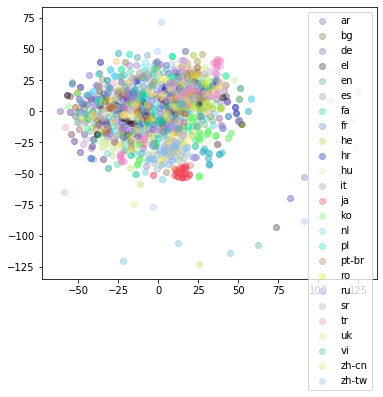

In [184]:
random.shuffle(data_with_states)
vecs = np.array([d["vec"] for d in data_with_states][:])
labels_lang = np.array([d["lang"] for d in data_with_states][:])
tsne(vecs[:1500], labels_lang[:1500])

## Classify language

In [185]:
l = int(len(vecs) * 0.9)
x_train_cls, x_dev_cls = vecs[:l], vecs[l:]
y_train_cls, y_dev_cls = labels_lang[:l], labels_lang[l:]
model = SGDClassifier(max_iter = 1000, alpha = 0.01)
model.fit(x_train_cls, y_train_cls)
print(model.score(x_dev_cls, y_dev_cls))

0.9266666666666666


## Create dataset for INLP

In [186]:
num_examples_per_language = 2000
vecs1, vecs2, labels = [], [], []
for lang in langs:
    relevant = [d for d in data_with_states if d["lang"] == lang]
    rest = [d for d in data_with_states if d["lang"] != lang]
    for i in range(num_examples_per_language):
        positive_pair = random.choice(relevant)["vec"], random.choice(relevant)["vec"]
        negative_pair = random.choice(relevant)["vec"], random.choice(rest)["vec"]
        
        # positive
        
        vecs1.append(positive_pair[0])
        vecs2.append(positive_pair[1])
        labels.append(1)
        
        # negative 
        vecs1.append(negative_pair[0])
        vecs2.append(negative_pair[1])
        labels.append(0)

vecs1, vecs2, labels = sklearn.utils.shuffle(vecs1, vecs2, labels)
vecs1 = np.array(vecs1)
vecs2 = np.array(vecs2)
labels = np.array(labels)
print(vecs1.shape, vecs2.shape, labels.shape)
l = int(len(vecs1) * 0.9)
x_train1, x_dev1 = vecs1[:l], vecs1[l:]
x_train2, x_dev2 = vecs2[:l], vecs2[l:]
y_train, y_dev = labels[:l], labels[l:]

"""
concat_train = np.concatenate([x_train1, x_train2], axis = 1)
concat_dev = np.concatenate([x_dev1, x_dev2], axis = 1)
model = SGDClassifier(max_iter = 1000, alpha = 0.1)
model.fit(concat_train, y_train)
print(model.score(concat_dev, y_dev))
"""

(100000, 768) (100000, 768) (100000,)


'\nconcat_train = np.concatenate([x_train1, x_train2], axis = 1)\nconcat_dev = np.concatenate([x_dev1, x_dev2], axis = 1)\nmodel = SGDClassifier(max_iter = 1000, alpha = 0.1)\nmodel.fit(concat_train, y_train)\nprint(model.score(concat_dev, y_dev))\n'

## Siamese INLP

In [169]:
inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 20, "input_dim": 768, "hidden_dim": 25, "batch_size": 64, "verbose": False, "device": "cpu",
         "compare_by": "dot_product", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = False)

### Try several different INLP dimensions



  0%|          | 0/1 [00:00<?, ?it/s]

         Name               Type Params
0          l1             Linear   19 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  




iteration: 0, accuracy: 0.8667396306991577:   0%|          | 0/1 [04:58<?, ?it/s]

iteration: 0, accuracy: 0.8667396306991577: 100%|██████████| 1/1 [05:01<00:00, 301.18s/it]


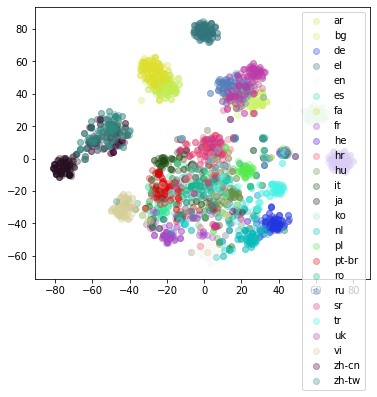

In [170]:
for num_classifiers in [1]:
    P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = num_classifiers, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)
    P_rowspace = np.eye(P.shape[0]) - P
    tsne(P_rowspace.dot(vecs.T).T[:2000], labels_lang[:2000])

## Classification INLP

In [187]:
inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train_cls, y_train_cls, x_dev_cls, y_dev_cls, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False, "max_iter": 5000})
inlp_model_handler = inlp_linear_model.SKlearnClassifier(SGDClassifier, {"max_iter": 10000, "alpha": 0.0001, "n_iter_no_change": 10})

# Try several different INLP dimensions



  0%|          | 0/3 [00:00<?, ?it/s]

iteration: 0, accuracy: 0.928:   0%|          | 0/3 [00:15<?, ?it/s]

iteration: 0, accuracy: 0.928:  33%|███▎      | 1/3 [00:15<00:30, 15.29s/it]

iteration: 1, accuracy: 0.7653333333333333:  33%|███▎      | 1/3 [00:56<00:30, 15.29s/it]

iteration: 1, accuracy: 0.7653333333333333:  67%|██████▋   | 2/3 [00:57<00:23, 23.30s/it]

iteration: 2, accuracy: 0.688:  67%|██████▋   | 2/3 [02:32<00:23, 23.30s/it]             

iteration: 2, accuracy: 0.688: 100%|██████████| 3/3 [02:32<00:00, 50.85s/it]


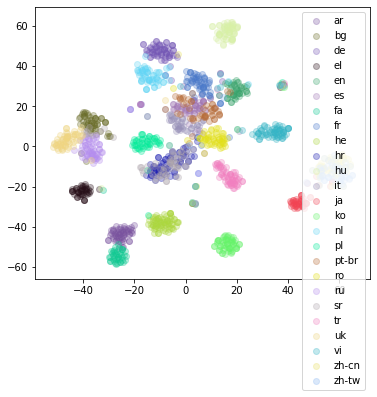

In [215]:
for num_classifiers in [3]:
    P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = num_classifiers, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)
    P_rowspace = np.eye(P.shape[0]) - P
    tsne(P_rowspace.dot(vecs.T).T[:1500], labels_lang[:1500])

In [ ]:
concat = np.concatenate(Ws, axis = 0)
P_rowspace_concat = inlp.get_rowspace_projection(concat)
tsne(P_rowspace_concat.dot(vecs.T).T[:1200], labels_lang[:1200])

In [ ]:
vecs_projected_low_dim = []
for w in Ws:
    w_normalized = w / np.linalg.norm(w, axis = 1, keepdims = True)
    w_projection = w_normalized.dot(vecs.T).T
    vecs_projected_low_dim.append(w_projection)

vecs_projected_low_dim = np.concatenate(vecs_projected_low_dim, axis = 1)
tsne(vecs_projected_low_dim[:1200], labels_lang[:1200])

In [ ]:
concat_normalized = concat / np.linalg.norm(concat, axis = 1, keepdims = True)
vecs_projected_low_dim2 = concat_normalized.dot(vecs.T).T
vecs_projected_low_dim2[0][:5], vecs_projected_low_dim[0][:5]

### Draw a dendrogram

In [211]:
lang_vecs = {}
for lang in langs:
       relevant = [d for d in data_with_states if d["lang"] == lang]
       vecs_relevant = np.array([d["vec"] for d in relevant])
       vecs_relevant = P_rowspace_concat.dot(vecs_relevant.T).T
       #vecs_relevant = concat_normalized.dot(vecs_relevant.T).T
       #vecs_relevant = P.dot(vecs_relevant.T).T
       lang_vecs[lang] = np.mean(vecs_relevant, axis = 0)

In [212]:
vecs_relevant.shape

(576, 768)

In [213]:
vecs_for_all_languages = [lang_vecs[lang] for lang in langs]

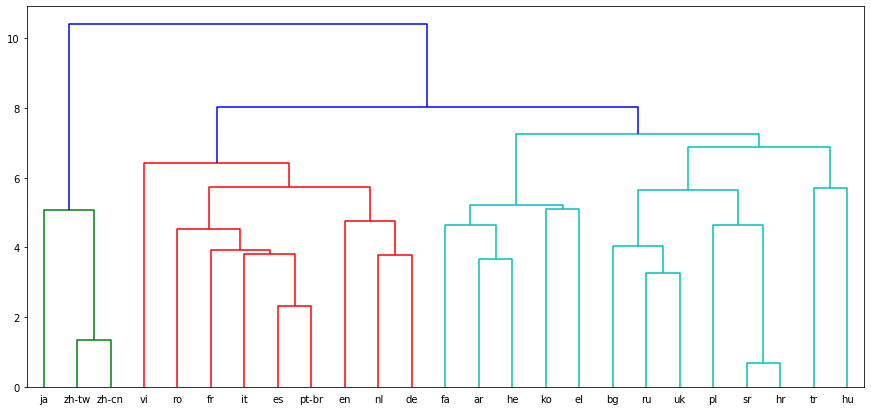

In [214]:
linked = linkage(vecs_for_all_languages, 'ward')
plt.figure(figsize=(15, 7))
dendrogram(
            linked,
            orientation='top',
            labels=langs,
            distance_sort='descending',
            show_leaf_counts=False,
            leaf_rotation = 0
          )
plt.show()

### Do word vectors cluster by canonical word order?

In [178]:
SVO = {"en", "ru", "he"}
SOV = {"de", "nl", "ja", "ko", "fa"}
data_for_word_order = []

for word_order_group, word_order in zip([SVO, SOV], ["SVO", "SOV"]):
    for lang in word_order_group:
        print(lang)
        relevant = [d for d in data_with_states if d["lang"] == lang]
        vecs_relevant = np.array([d["vec"] for d in relevant])
        vecs_relevant = concat_normalized.dot(vecs_relevant.T).T
        for v in vecs_relevant:
            data_for_word_order.append((v, word_order))

en
he
ru
ko
fa
ja
nl
de


In [179]:
random.shuffle(data_for_word_order)
vecs_word_ordr, labels_word_order = map(np.array, zip(*data_for_word_order))

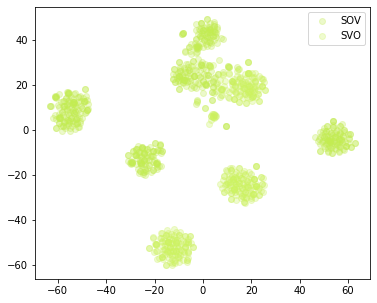

In [181]:
tsne(vecs_word_ordr[:1000], labels_word_order[:1000])

In [153]:
en = [d for d in all_data if d["lang"] == "en"]
en[0]

{'text': "Amongst all the troubling deficits we struggle with today — we think of financial and economic primarily — the ones that concern me most is the deficit of political dialogue — our ability to address modern conflicts as they are , to go to the source of what they 're all about and to understand the key players and to deal with them .",
 'lang': 'en'}

In [127]:
q = [d for d in all_data if d["lang"] == "ru"]

In [133]:
q[50]

{'text': 'Диалог это очень нелегко — и для индивидуумов , и для групп , и для государств — но это крайне необходимо .',
 'lang': 'ru'}